# [A detailed use case: TSS plots](https://htseq.readthedocs.io/en/release_0.11.1/tss.html)

A common task in **ChIP-Seq analysis** is to get profiles of marks with respect to nearby features. For example, when analysing histone marks, one is often interested in the position and extend of such marks in the vicinity of **transcription start sites (TSSs)**. To this end, one commonly calculates the **coverage of reads** or fragments across the whole genome, then marks out fixed-size windows centered around the TSSs of all genes, takes the coverages in these windows and adds them up to a “profile” that has the size of the window. This is a simple operation, which, however, can become challenging, when working with large genomes and very many reads.

Here, we demonstrate various ways of how data flow can be organized in *HTSeq* by means of different solutions to this task.

As example data, we use a short excerpt from the data set by *Barski et al. (Cell, 2007, 129:823)*. 
* We downloaded the `FASTQ` **file** for one of the H3K4me3 samples (Short Read Archive accession number SRR001432)
* **Aligned** it against the Homo sapiens genome build GRCh37 with `BWA`, and provide the start of this file (actually only containing reads aligned to chromosome 1) as `file SRR001432_head.bam` with the *HTSeq* example files.

* As **annotation**, we use the file `Homo_sapiens.GRCh37.56_chrom1.gtf`, which is the part of the Ensembl GTF file for Homo sapiens for chromosome 1.

## Using the full coverage

We start with the straight-forward way of calculating the full coverage first and then summing up the profile. This can be done as described in the [Tour](https://htseq.readthedocs.io/en/release_0.11.1/tour.html#tour):

In [1]:
import HTSeq

# select bam file: instantiate BAM_Reader Object
bam_file = HTSeq.BAM_Reader("data/SRR001432_head.bam")
# select gtf file: instantiate GFF_Reader Object
gtf_file = HTSeq.GFF_Reader("data/Homo_sapiens.GRCh37.56_chrom1.gtf")

## instantiate a `GenomicArray` object for the coverage(`cvg`):
coverage = HTSeq.GenomicArray("auto", stranded=False, typecode="i")

## simply iterate through all the reads 
for aln in bam_file:
    if aln.aligned:
        coverage[aln.iv] += 1

To find the location of all **transcription start sites**, we can look in the `GTF` file for **exons** with **exon number 1** (as indicated by the `exon_number` attribute in Ensembl `GTF` files) and ask for their directional start (`start_d`). The following loop extracts and prints this information (using `itertools.islice `to go through only the first 100 features in the `GTF` file):

In [2]:
import itertools
for feature in itertools.islice(gtf_file, 100):
    
    # transcription start sites are defined by  exons with exon number 1
    if feature.type == "exon" and feature.attr["exon_number"] == "1":
        print(feature.attr["gene_id"], feature.attr["transcript_id"], feature.iv.start_d_as_pos)
        

ENSG00000223972 ENST00000456328 1:11873/+
ENSG00000223972 ENST00000450305 1:12009/+
ENSG00000227232 ENST00000423562 1:29369/-
ENSG00000227232 ENST00000438504 1:29369/-
ENSG00000227232 ENST00000488147 1:29569/-
ENSG00000227232 ENST00000430492 1:29342/-
ENSG00000243485 ENST00000473358 1:29553/+
ENSG00000243485 ENST00000469289 1:30266/+
ENSG00000221311 ENST00000408384 1:30365/+
ENSG00000237613 ENST00000417324 1:36080/-
ENSG00000237613 ENST00000461467 1:36072/-
ENSG00000233004 ENST00000421949 1:53048/+
ENSG00000240361 ENST00000492842 1:62947/+
ENSG00000177693 ENST00000326183 1:69054/+


As the `GTF` file contains several transcripts for each gene, one *TSS* may appear multiple times, giving undue weight to it. Hence, we collect them in a set as this data type enforces uniqueness.

In [3]:
tss_pos = set()
for feature in gtf_file:
    
    # transcription start sites are defined by  exons with exon number 1
    if feature.type == "exon" and feature.attr["exon_number"] == "1":
        tss_pos.add(feature.iv.start_d_as_pos)

Let’s take one of these starting positions using the `GenomicPosition` **class**. To get a nice one, we manually chose this one here, just for demonstration purposes:

In [4]:
p = HTSeq.GenomicPosition("1", 145439814, "+")

This is really one of the TSSs in the set

In [5]:
p in tss_pos

True

We can get a window centered on this *TSS* by just subtracting and adding a fixed value (**half of the desired window size**, let’s use 3 `kb`), using the `GenomicInterval` class:

In [6]:
half_window_width = 3000
window = HTSeq.GenomicInterval(p.chrom, p.pos - half_window_width, p.pos + half_window_width, ".")
window

<GenomicInterval object '1', [145436814,145442814), strand '.'>

We can check the `coverage` in this window by **subsetting** and **transforming** to a list:

In [ ]:
#list(coverage[ window ])

As we will work with `numpy` from now on, it may be better to get this as `numpy array`:

In [8]:
import numpy as np
window_cvg =  np.fromiter(coverage[window], dtype='i', count=2*half_window_width)
window_cvg

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

With `matplotlib`, we can see that this vector is, in effect, not all zero:

In [9]:
from matplotlib import pyplot as plt
plt.plot(window_cvg)
plt.show()

<Figure size 640x480 with 1 Axes>

To sum up the profile, we initialize a numpy vector of the size of our window with zeroes:

In [11]:
profile = np.zeros(2*half_window_width, dtype='i')

Now, we can go through the all the *TSS* positions and add the **coverage** in their windows to get the profile:

In [13]:
for p in tss_pos:
    
    window = HTSeq.GenomicInterval(p.chrom, p.pos - half_window_width, p.pos + half_window_width, ".")
    window_cvg = np.fromiter(coverage[window], dtype='i', count=2*half_window_width)
    
    ## add to global profile
    if p.strand == '+':
        profile += window_cvg
    else:
        # add the window coverage reversed (“[::-1]”) if the gene was on the minus strand.
        profile += window_cvg[::-1]

Note that we add the window coverage reversed (`[::-1]`) if the gene was on the minus strand.

Using matplotlib, we can plot this:

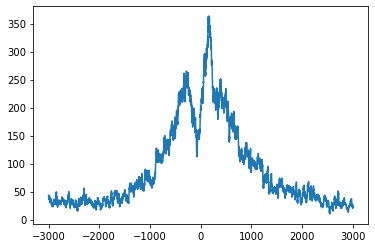

In [14]:
plt.plot(np.arange(-half_window_width, half_window_width), profile)
plt.show()

We can see clearly that the **reads concentrate** around the **TSS**, with a prominent peak a bit downstream (if you use matplotlib’s interactive zoom, you can easily see that the peak is at `153 bp`) and a dip upstream, at `-79 bp`.

Going back to the beginning, there is **one possible improvement**: When calculating the **coverage**, we just added one to all the base pairs that the read covered. However, the fragment extends beyond the read, to a length of about `200 bp` (the fragment size for which Barski et al. selected). Maybe we get a better picture by calculating the coverage not from the reads but from the fragments, i.e., the reads extended to fragment size. For this, we just one line, to extend the read to `200 bp`.

Using this, we now put the whole script together:

In [16]:
import HTSeq
import numpy as np
from matplotlib import pyplot as plt

# select bam file: instantiate BAM_Reader Object
bam_file = HTSeq.BAM_Reader("data/SRR001432_head.bam")
# select gtf file: instantiate GFF_Reader Object
gtf_file = HTSeq.GFF_Reader("data/Homo_sapiens.GRCh37.56_chrom1.gtf")

## define window and fragment size
half_window_width = 3000
fragment_size = 200

## instantiate a `GenomicArray` object for the coverage(`cvg`):
coverage = HTSeq.GenomicArray("auto", stranded=False, typecode="i")

## simply iterate through all the reads 
for aln in bam_file:
    if aln.aligned:
        ## possible improvement - change read interval extending to fragment size
        aln.iv.length = fragment_size
        coverage[ aln.iv ] += 1

tss_pos = set()
for feature in gtf_file:
    
    # transcription start sites are defined by  exons with exon number 1
    if feature.type == "exon" and feature.attr["exon_number"] == "1":
        tss_pos.add(feature.iv.start_d_as_pos)

profile = np.zeros( 2*half_window_width, dtype='i' )      
for p in tss_pos:
    window = HTSeq.GenomicInterval(p.chrom, p.pos - half_window_width, p.pos + half_window_width, ".")
    window_cvg = np.fromiter(coverage[ window ], dtype='i', count=2*half_window_width )
    
    ## add to global profile
    if p.strand == "+":
        profile += window_cvg
    else:
        profile += window_cvg[::-1]

The script produces a profile variable which we can plot by adding these lines to it:

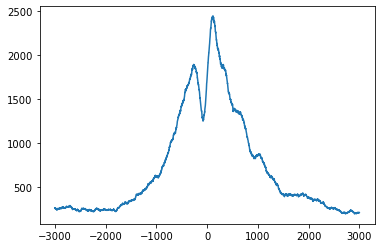

In [18]:
plt.plot(np.arange(-half_window_width, half_window_width), profile)
plt.show()

The plot looks much smoother with the extended fragments.

The **coverage vector** can be held in memory, even for a very large genome, because large parts of it are zero and even where there are reads, the values tend to stay constant for stretches of several bases. Hence, `GenomicArray`’s `step storage` **mode** is useful.

If, however, **extremely large amounts of reads** are processed, the coverage vector can become “rough” and change value at every position. Then, the `step storage` **mode** becomes inefficient and we might be better off with an ordinary dense vector such as provided by `numpy`.

As this numpy vector becomes **very large**, it may not fit in memory, and the `memmap` **storage** (using numpy’s memmap facility) then uses temporary files on disk. We mention these possibilities as they may be useful when working with the full coverage vector is required. Here, however, we can do otherwise.

## Using indexed BAM files

We do not need the **coverage from everywhere**. We only need it close to the *TSSs*. We can **sort** our `BAM` **file** by position (`samtools sort`) and **index** it (`samtools index`) and then use **random access**, as *HTSeq* exposes this functionality of `SAMtools`.

<font color='red'> To be continued ... </font>